### This notebook demonstrates the alternative DCTR fitting method applied on Lund jet datasets

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import numpy as np

In [3]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import keras.backend as K
import pickle

from keras.layers import Lambda, Dense, Input, Layer, Dropout, Dot, Flatten
from keras.models import Model

Using TensorFlow backend.
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflo

In [4]:
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt

## Utilities

In [6]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [7]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [8]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=True)

#load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_alphaS.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 7)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    800         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [9]:
test_dataset_0 = np.load('test1D_default.npz')
test_dataset_1 = np.load('test1D_alphaS.npz')

In [10]:
dctr

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3663935934509653964
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10913290650
locality {
  bus_id: 1
  links {
  }
}
incarnation: 403696317900072729
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]



## Load Data

In [12]:
X_default = preprocess_data(test_dataset_0['jet'][:,:,:4])
X_unknown = preprocess_data(test_dataset_1['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [13]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [14]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.2, shuffle=True)

In [15]:
num_data_test = 300000
X_train = X_train[:num_data_test,:,:]
X_test = X_test[:int(num_data_test/5),:,:]

In [16]:
Y_train = Y_train[:num_data_test]
Y_test = Y_test[:int(num_data_test/5)]

In [17]:
fixed_aLund_value = 0.680
fixed_probStuUD_value = 0.217

# Fitting

In [18]:
def reweight(d): #from NN (DCTR)
    f = dctr.model(d) # Use dctr.model.predict_on_batch(d) when using outside training
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

### DNN Model

In [19]:
myinputs = Input(shape=(204,))

x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=myinputs, outputs=predictions)
model.summary()


batch_size = 1000

def my_loss_wrapper(myinputs, theta):
    
    val = theta
    
    x = tf.gather(myinputs, np.arange(batch_size))
    x = tf.reshape(myinputs, [batch_size,51,4])
    
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    theta_prime = [val, 0.68, 0.217]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    weight = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 204)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               26240     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 42,881
Trainable params: 42,881
Non-trainable params: 0
_________________________________________________________________


In [20]:
thetas = np.linspace(0.10, 0.18, 33)
lvals = []
vlvals = []

for theta in thetas:
    print("theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train.reshape(-1,204), Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test.reshape(-1,204), Y_test),verbose=1)
    vlvals+=[history.history['val_loss']]
    lvals+=[history.history['loss']]
    print
    pass
print(lvals)

theta = : 0.1
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 9s 30us/step - loss: 0.2248 - acc: 0.5636 - val_loss: 0.2229 - val_acc: 0.5648
theta = : 0.10250000000000001
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 9s 30us/step - loss: 0.2215 - acc: 0.5703 - val_loss: 0.2223 - val_acc: 0.5673
theta = : 0.10500000000000001
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 9s 30us/step - loss: 0.2212 - acc: 0.5727 - val_loss: 0.2223 - val_acc: 0.5684
theta = : 0.1075
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 9s 30us/step - loss: 0.2211 - acc: 0.5762 - val_loss: 0.2228 - val_acc: 

[[0.22476318185528119], [0.22154993330438932], [0.2211584762732188], [0.22106375187635421], [0.22146473651130993], [0.22211986914277076], [0.22320558254917464], [0.22442708149552346], [0.22574443424741428], [0.22720732614398004], [0.2286302725970745], [0.22995368167757987], [0.2313411910335223], [0.2325641867518425], [0.2339372044801712], [0.23527307892839114], [0.23661517575383187], [0.2376415178179741], [0.23854154760638874], [0.23907653614878654], [0.2394607201218605], [0.23953423882524172], [0.2393741533656915], [0.238763041049242], [0.23801078498363495], [0.2370383087793986], [0.2358545299867789], [0.23457353184620539], [0.2331427992383639], [0.23162320663531621], [0.2297330796221892], [0.22804910123348235], [0.22626195912559827]]


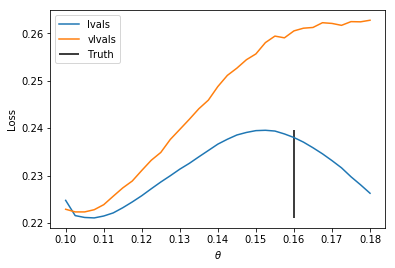

In [21]:
plt.plot(thetas,lvals, label = "lvals")
plt.plot(thetas,vlvals, label = "vlvals")
plt.vlines(0.160, ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.show()

## PFN Model

In [22]:
model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs = model.inputs[0]



batch_size = 1000

def my_loss_wrapper(myinputs, theta):
    val = theta
    x  = myinputs[:,:,:4] #x.shape = (?,?,4)
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    theta_prime = [val, 0.68, 0.217]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    weight = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    
    return my_loss

In [23]:
thetas = np.linspace(0.10, 0.18, 33)
lvals = []
vlvals = []

for theta in thetas:
    print("theta = :", theta)
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1)
    lvals+=[history.history['loss']]
    vlvals+=[history.history['val_loss']]
    print
    pass
print(lvals)

theta = : 0.1
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 13s 42us/step - loss: 0.2202 - acc: 0.5708 - val_loss: 0.2174 - val_acc: 0.5689
theta = : 0.10250000000000001
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 13s 43us/step - loss: 0.2167 - acc: 0.5767 - val_loss: 0.2165 - val_acc: 0.5751
theta = : 0.10500000000000001
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 13s 43us/step - loss: 0.2161 - acc: 0.5788 - val_loss: 0.2163 - val_acc: 0.5746
theta = : 0.1075
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 13s 43us/step - loss: 0.2171 - acc: 0.5795 - val_loss: 0.2177 - val_a

[[0.22022453476985296], [0.21668540691335997], [0.21613288978735606], [0.21709210296471915], [0.21812252114216488], [0.21976363589366277], [0.22153407682975132], [0.22328483824928602], [0.22545551444093387], [0.22752769470214843], [0.22973784759640695], [0.23171564141909282], [0.2338728778064251], [0.2356310347219308], [0.23793739954630533], [0.2400190995136897], [0.24210765103499093], [0.2439700508117676], [0.24565805708368618], [0.24702712992827097], [0.24818054194251696], [0.24903685887654622], [0.24965299780170122], [0.24988977283239364], [0.24992611661553382], [0.24972011307875316], [0.24920724734663963], [0.248510965804259], [0.2476109121243159], [0.24660340790947277], [0.24538915783166884], [0.24416201278567315], [0.2427470842997233]]


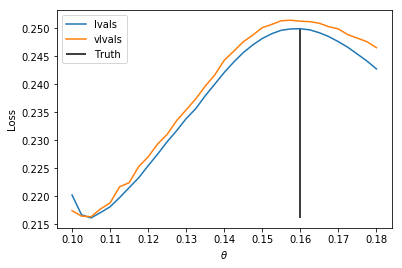

In [24]:

plt.plot(thetas,lvals, label = "lvals")
plt.plot(thetas,vlvals, label = "vlvals")
plt.vlines(0.160, ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

### (g,theta) fit for DNN Model

In [26]:
from keras.layers import Lambda
from keras.models import Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 204)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               26240     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 42,881
Trainable params: 42,881
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 204)               0         
_________________________________________________________________
dense_

300000/300000 [==============================] - 10s 35us/step - loss: -0.2527 - acc: 0.5723 - val_loss: -0.2620 - val_acc: 0.5635
. theta fit =  0.17733862
Theta fit value is 0.17733862
Epoch:  13
Training g
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 9s 31us/step - loss: 0.2472 - acc: 0.5192 - val_loss: 0.2489 - val_acc: 0.4618
. theta fit =  0.17733862
Training theta
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 11s 35us/step - loss: -0.2490 - acc: 0.4729 - val_loss: -0.2534 - val_acc: 0.4618
. theta fit =  0.14142123
Theta fit value is 0.14142123
Epoch:  14
Training g
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 10s 32us/step - loss: 0.2453 - acc: 0.5567 - val_loss: 0.2474 - val_acc: 0.5606
. theta fit =  0.14142123
Training theta
Train on 300000 samples, validate on 60000 samples
Epoch 1/1

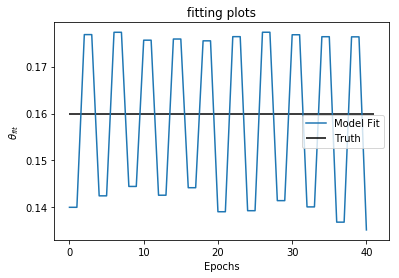

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.14
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

myinputs = Input(shape=(204,))
x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
dnn_model = Model(inputs=myinputs, outputs=predictions)
dnn_model.summary()

myinputs_fit = dnn_model.inputs[0]
identity = Lambda(lambda x: x + 0)(dnn_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = int(len(X_train)/50) #larger batch_size leads to better precision (at least for Guassian case)
epochs = 20 #but requires more epochs to train


def my_loss_wrapper_fit(myinputs, train_theta, mysign = 1):  
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
        
    x = tf.gather(myinputs, np.arange(batch_size))
    x = tf.reshape(myinputs, [batch_size,51,4])
    
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    theta_prime = [theta0, 0.68, 0.217]
    
    # Add MC params to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0,
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    weight = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):  
    
    theta0 = model_fit.layers[-1].get_weights() 
    print("Theta fit value is", theta0[0])
    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, 1),
                      metrics=['accuracy'])
    print("Training g")
    
    model_fit.fit(X_train.reshape(-1,204), Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test.reshape(-1,204), Y_test),verbose=1,callbacks=callbacks)

    
    #######################################################################################
    #Now, fix g and train \theta.
    
    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit, train_theta, -1),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_train.reshape(-1,204), Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test.reshape(-1,204), Y_test),verbose=1,callbacks=callbacks)
 
    pass

plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("fitting plots")
plt.show()

## Adi's version

In [28]:
model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs = model.inputs[0]
batch_size = 1000

def my_loss_wrapper(inputs, val=0):
    x  = inputs #x.shape = (?,?,4)
    #Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event

    theta_prime = [val, 0.68, 0.217]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    w = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean-Squared Loss:
        t_loss = (y_true)*(y_true - y_pred)**2 +(w)*(1-y_true)*(y_true - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

In [29]:
thetas = np.linspace(0.10, 0.18, 33) #iterating across possible alphaS values
vlvals = []
lvals = []


for theta in thetas:
    print("trainnig theta = :", theta)
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1)
    vlvals+=[history.history['val_loss']]
    lvals+=[history.history['loss']]
    print
    pass
print(lvals)

trainnig theta = : 0.1
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 19s 62us/step - loss: 0.2223 - acc: 0.5702 - val_loss: 0.2189 - val_acc: 0.5728
trainnig theta = : 0.10250000000000001
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 19s 63us/step - loss: 0.2168 - acc: 0.5765 - val_loss: 0.2163 - val_acc: 0.5709
trainnig theta = : 0.10500000000000001
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 19s 63us/step - loss: 0.2162 - acc: 0.5791 - val_loss: 0.2159 - val_acc: 0.5755
trainnig theta = : 0.1075
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 19s 64us/step - loss: 0.2171 - acc: 0.5803 - val_loss: 0.2185 - val_acc: 0.5778
trainnig theta = : 0.11
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [=============

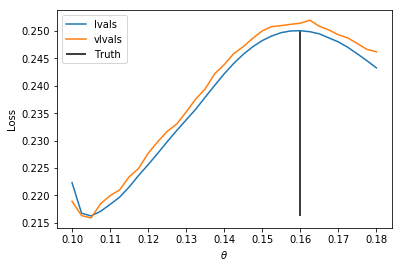

In [30]:
plt.plot(thetas,lvals, label = "lvals")
plt.plot(thetas,vlvals, label = "vlvals")
plt.vlines(0.160, ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback


In [32]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.12
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [33]:
def reweight(d): #from NN (DCTR)
    f = dctr.model(d) # Use dctr.model.predict_on_batch(d) when using outside training
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

PFN_model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = int(len(X_train)/20) #larger batch_size leads to better precision (at least for Guassian case)
epochs = 15 #but requires more epochs to train

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    
    
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
        
    theta_prime = [theta0, 0.68, 0.217]
    
    # zip theta_prime to each input particle (but not to the padded rows)
    concat_input_and_params = tf.where(K.abs(x[...,0])>0, #checks if pT != 0, which means we have a particle
                                   K.ones_like(x[...,0]),
                                   K.zeros_like(x[...,0]))
    
    concat_input_and_params = theta_prime*K.stack([concat_input_and_params, concat_input_and_params, concat_input_and_params], axis = -1)
    
    data = K.concatenate([x, concat_input_and_params], -1)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    weight = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)    
    pass

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_22[0][0]              
__________________________________________________________________________________________________
activation

300000/300000 [==============================] - 16s 54us/step - loss: -0.2506 - acc: 0.5492 - val_loss: -0.2517 - val_acc: 0.5441
. theta fit =  0.16401786
Epoch:  9
Training g
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 17s 55us/step - loss: 0.2509 - acc: 0.4996 - val_loss: 0.2510 - val_acc: 0.4790
. theta fit =  0.16401786
Training theta
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 17s 55us/step - loss: -0.2506 - acc: 0.4793 - val_loss: -0.2512 - val_acc: 0.4790
. theta fit =  0.15428115
Epoch:  10
Training g
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 17s 55us/step - loss: 0.2509 - acc: 0.5268 - val_loss: 0.2510 - val_acc: 0.5496
. theta fit =  0.15428115
Training theta
Train on 300000 samples, validate on 60000 samples
Epoch 1/1
300000/300000 [==============================] - 17s 56us/s

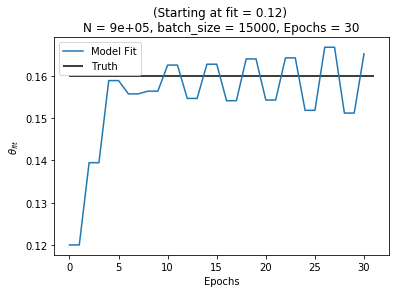

In [34]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("(Starting at fit = 0.12) \nN = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(len(X_default), batch_size, epochs*2))
plt.savefig("(Starting at fit = 0.12) N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}.png".format(len(X_default), batch_size, epochs))
plt.show()